In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spec_id import Gauss_dist

In [11]:
def Gauss_dist(x, mu, sigma):
    Co = (1 / (sigma * np.sqrt(2 * np.pi)))
    E = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)).astype(np.float128)
    C = np.trapz(E*Co, x)
    G = E*Co / C
    return G

In [25]:
def Eff_wv(wv,t):
    tp = np.trapz(((t * np.log(wv)) / wv), wv)
    bm = np.trapz(t / wv, wv)

    return np.exp(tp / bm)

In [48]:
def FWHM(wv,t,effwv):
    top = np.trapz((t * np.log(wv/effwv)**2) / wv, wv)
    bot = np.trapz(t / wv, wv)
    sigma = np.sqrt(top/bot)
    print sigma *effwv
    return np.sqrt(8*np.log(2))*sigma

In [51]:
wv=np.arange(1,9.001,.001)
dist = Gauss_dist(wv,5,.3)

In [33]:
wv

array([ 1.  ,  1.01,  1.02,  1.03,  1.04,  1.05,  1.06,  1.07,  1.08,
        1.09,  1.1 ,  1.11,  1.12,  1.13,  1.14,  1.15,  1.16,  1.17,
        1.18,  1.19,  1.2 ,  1.21,  1.22,  1.23,  1.24,  1.25,  1.26,
        1.27,  1.28,  1.29,  1.3 ,  1.31,  1.32,  1.33,  1.34,  1.35,
        1.36,  1.37,  1.38,  1.39,  1.4 ,  1.41,  1.42,  1.43,  1.44,
        1.45,  1.46,  1.47,  1.48,  1.49,  1.5 ,  1.51,  1.52,  1.53,
        1.54,  1.55,  1.56,  1.57,  1.58,  1.59,  1.6 ,  1.61,  1.62,
        1.63,  1.64,  1.65,  1.66,  1.67,  1.68,  1.69,  1.7 ,  1.71,
        1.72,  1.73,  1.74,  1.75,  1.76,  1.77,  1.78,  1.79,  1.8 ,
        1.81,  1.82,  1.83,  1.84,  1.85,  1.86,  1.87,  1.88,  1.89,
        1.9 ,  1.91,  1.92,  1.93,  1.94,  1.95,  1.96,  1.97,  1.98,
        1.99,  2.  ,  2.01,  2.02,  2.03,  2.04,  2.05,  2.06,  2.07,
        2.08,  2.09,  2.1 ,  2.11,  2.12,  2.13,  2.14,  2.15,  2.16,
        2.17,  2.18,  2.19,  2.2 ,  2.21,  2.22,  2.23,  2.24,  2.25,
        2.26,  2.27,

In [52]:
effwv =  Eff_wv(wv,dist)
print effwv
fwhm = FWHM(wv,dist,effwv)
print fwhm *effwv
print np.sqrt(8*np.log(2))*.3

4.97276006404
0.30138960605
0.709718285691
0.706446013509


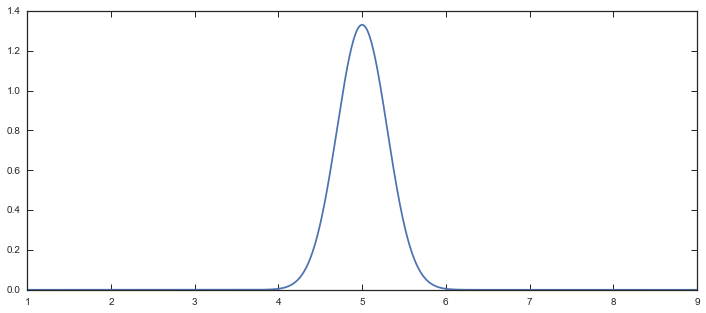

In [53]:
%matplotlib inline

plt.figure(figsize=[12,5])
plt.plot(wv,dist)
plt.show()
plt.close()